# Imports

In [1]:
import matplotlib.pyplot as plt
import random
import sys
sys.path.append('../src')

from data import *
from model import *
from train import *
import random
from make_cosmic_web import *

from torch_geometric.nn import aggr
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
from ranger21 import Ranger21

import cmasher as cmr
from tqdm.notebook import tqdm

ROOT = Path("..").resolve()
tng_base_path = f"{ROOT}/illustris_data/TNG300-1/output"

seed = 255
rng = np.random.RandomState(seed)
random.seed(seed)
torch.manual_seed(seed)

c0, c1, c2, c3, c4 = '#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600'

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [6]:
reload = True #force a reload of the data to change cuts, use_loops, periodic or use_loops

## get illustris positions
snapshot = 99
h = 0.704 # cosmology h, set to 1 if you want comoving Mpc

r_link = 5 #Mpc

in_projection = False
proj_str = "-projected" if in_projection else ""

cuts = {"minimum_log_stellar_mass": 9,
        "minimum_log_halo_mass": 10,
       "minimum_n_star_particles": 50}

undirected = True
periodic = False
use_loops = True

aggr = "max" # aggregation/pooling function; can be list of multiple 

use_gal = False # True = use galaxy params to infer dark matter, False = use DM params to infer galaxy stuff

pad = r_link / 2 # how much padding to add around each subbox, so the separation in total will be 2 times this

split = 6 # N_subboxes = split**3

train_test_frac_split = 36

data_path = osp.join(tng_base_path, 'cosmic_graphs', f'split_{split**3}_link_{int(r_link)}_pad{int(pad)}_gal{int(use_gal)}{proj_str}.pkl')


In [7]:
def make_webs(
    tng_base_path="../illustris_data/TNG300-1/output", 
    data_path=None,
    snapshot=99, 
    r_link=5,
    pad=2.5,
    split=6,
    cuts=cuts, 
    use_gal=False, 
    h=0.704, 
    undirected=True, 
    periodic=False, 
    use_loops=True,
    in_projection=False,
    normalization_params=normalization_params
):
    
    if use_gal:
        # use_cols = ['subhalo_x', 'subhalo_y', 'subhalo_z', 'subhalo_vx', 'subhalo_vy', 'subhalo_vz','subhalo_logstellarmass', 'subhalo_stellarhalfmassradius']
        use_cols = ['subhalo_x', 'subhalo_y', 'subhalo_z', 'subhalo_vx', 'subhalo_vy', 'subhalo_vz','subhalo_logstellarmass']
        y_cols = ['subhalo_loghalomass', 'subhalo_logvmax'] 
    else:
        use_cols = ['subhalo_x', 'subhalo_y', 'subhalo_z', 'subhalo_vx', 'subhalo_vy', 'subhalo_vz', 'subhalo_loghalomass', 'subhalo_logvmax'] 
        # y_cols = ['subhalo_logstellarmass', 'subhalo_stellarhalfmassradius']
        y_cols = ['subhalo_logstellarmass']

    if in_projection:
        for c in ['subhalo_z', 'subhalo_vx', 'subhalo_vy']:
            use_cols.remove(c)

    subhalo_fields = [
            "SubhaloPos", "SubhaloMassType", "SubhaloLenType", "SubhaloHalfmassRadType", 
            "SubhaloVel", "SubhaloVmax", "SubhaloGrNr", "SubhaloFlag"
        ]
    subhalos = il.groupcat.loadSubhalos(tng_base_path, snapshot, fields=subhalo_fields) 

    pos = subhalos["SubhaloPos"][:,:3]
    min_box, max_box = np.rint(np.min(pos)), np.rint(np.max(pos))

    box_size = max_box/(h*1e3) # in Mpc


    halo_fields = ["Group_M_Crit200", "GroupFirstSub", "GroupPos", "GroupVel"]
    halos = il.groupcat.loadHalos(tng_base_path, snapshot, fields=halo_fields)

    subhalo_pos = subhalos["SubhaloPos"][:] / (h*1e3)
    subhalo_stellarmass = subhalos["SubhaloMassType"][:,4]
    subhalo_halomass = subhalos["SubhaloMassType"][:,1]
    subhalo_n_stellar_particles = subhalos["SubhaloLenType"][:,4]
    subhalo_stellarhalfmassradius = subhalos["SubhaloHalfmassRadType"][:,4]  / normalization_params["norm_half_mass_radius"]
    subhalo_vel = subhalos["SubhaloVel"][:] /  normalization_params["norm_velocity"]
    subhalo_vmax = subhalos["SubhaloVmax"][:] / normalization_params["norm_velocity"]
    subhalo_flag = subhalos["SubhaloFlag"][:]
    halo_id = subhalos["SubhaloGrNr"][:]

    halo_mass = halos["Group_M_Crit200"][:]
    halo_primarysubhalo = halos["GroupFirstSub"][:]  # currently not used but might be good for magnitude gap
    group_pos = halos["GroupPos"][:] / (h*1e3)
    group_vel = halos["GroupVel"][:]  / normalization_params["norm_velocity"]

    # get subhalos/galaxies      
    subhalos = pd.DataFrame(
        np.column_stack([halo_id, subhalo_flag, np.arange(len(subhalo_stellarmass)), subhalo_pos, subhalo_vel, subhalo_n_stellar_particles, subhalo_stellarmass, subhalo_halomass, subhalo_stellarhalfmassradius, subhalo_vmax]), 
        columns=['halo_id', 'subhalo_flag', 'subhalo_id', 'subhalo_x', 'subhalo_y', 'subhalo_z', 'subhalo_vx', 'subhalo_vy', 'subhalo_vz', 'subhalo_n_stellar_particles', 'subhalo_stellarmass', 'subhalo_halomass', 'subhalo_stellarhalfmassradius', 'subhalo_vmax'],
    )
    subhalos = subhalos[subhalos["subhalo_flag"] != 0].copy()
    subhalos['halo_id'] = subhalos['halo_id'].astype(int)
    subhalos['subhalo_id'] = subhalos['subhalo_id'].astype(int)

    subhalos.drop("subhalo_flag", axis=1, inplace=True)

    # impose stellar mass and particle cuts
    subhalos = subhalos[subhalos["subhalo_n_stellar_particles"] > cuts["minimum_n_star_particles"]].copy()
    subhalos["subhalo_logstellarmass"] = np.log10(subhalos["subhalo_stellarmass"] / h)+10

    subhalos["subhalo_loghalomass"] = np.log10(subhalos["subhalo_halomass"] / h)+10
    subhalos["subhalo_logvmax"] = np.log10(subhalos["subhalo_vmax"])
    subhalos["subhalo_logstellarhalfmassradius"] = np.log10(subhalos["subhalo_stellarhalfmassradius"])

    subhalos = subhalos[subhalos["subhalo_loghalomass"] > cuts["minimum_log_halo_mass"]].copy()

    subhalos = subhalos[subhalos["subhalo_logstellarmass"] > cuts["minimum_log_stellar_mass"]].copy()

    subhalos.reset_index(drop = True)

    data = []
    for n in tqdm(range(split), position=0):
        for g in tqdm(range(split), position=1, leave=False):
            for k in tqdm(range(split), position=2, leave=False):
                # print(n,g,k)
                xlims = np.array([box_size/split*n+pad, box_size/split*(n+1)-pad])
                ylims = np.array([box_size/split*g+pad, box_size/split*(g+1)-pad])
                zlims = np.array([box_size/split*k+pad, box_size/split*(k+1)-pad])

                pos = np.vstack(subhalos[['subhalo_x', 'subhalo_y', 'subhalo_z']].to_numpy())

                xmask = np.logical_and(pos[:,0]>xlims[0],pos[:,0]<xlims[1])
                ymask = np.logical_and(pos[:,1]>ylims[0],pos[:,1]<ylims[1])
                zmask = np.logical_and(pos[:,2]>zlims[0],pos[:,2]<zlims[1])
                mask = np.logical_and(zmask, np.logical_and(xmask, ymask))

                df = subhalos.iloc[mask].copy()
                df.reset_index(drop=True)

                # remove extraneous columns
                df.drop(["subhalo_n_stellar_particles", "subhalo_stellarmass", "subhalo_halomass"], axis=1, inplace=True)

                # set new zero point

                df[['subhalo_x', 'subhalo_y', 'subhalo_z']] = df[['subhalo_x', 'subhalo_y', 'subhalo_z']] - np.array([box_size/split*n+pad, box_size/split*g+pad, box_size/split*k+pad])

                #make positions for clustering
                
                if in_projection:
                    pos = np.vstack(df[['subhalo_x', 'subhalo_y']].to_numpy())    
                else:
                    pos = np.vstack(df[['subhalo_x', 'subhalo_y', 'subhalo_z']].to_numpy())

                kd_tree = ss.KDTree(pos, leafsize=25, boxsize=box_size)
                edge_index = kd_tree.query_pairs(r=r_link, output_type="ndarray")

                # normalize positions

                df[['subhalo_x', 'subhalo_y', 'subhalo_z']] = df[['subhalo_x', 'subhalo_y', 'subhalo_z']]/(box_size/2)

                if undirected:
                # Add reverse pairs
                    reversepairs = np.zeros((edge_index.shape[0],2))
                    for i, pair in enumerate(edge_index):
                        reversepairs[i] = np.array([pair[1], pair[0]])
                    edge_index = np.append(edge_index, reversepairs, 0)

                    edge_index = edge_index.astype(int)

                    # Write in pytorch-geometric format
                    edge_index = edge_index.reshape((2,-1))
                    num_pairs = edge_index.shape[1]

                row, col = edge_index

                diff = pos[row]-pos[col]
                dist = np.linalg.norm(diff, axis=1)

                if periodic:
                    # Take into account periodic boundary conditions, correcting the distances
                    for i, pos_i in enumerate(diff):
                        for j, coord in enumerate(pos_i):
                            if coord > r_link:
                                diff[i,j] -= box_size  # Boxsize normalize to 1
                            elif -coord > r_link:
                                diff[i,j] += box_size  # Boxsize normalize to 1

                centroid = np.mean(pos,axis=0) # define arbitrary coordinate, invarinat to translation/rotation shifts, but not stretches
                # centroid+=1.2

                unitrow = (pos[row]-centroid)/np.linalg.norm((pos[row]-centroid), axis=1).reshape(-1,1)
                unitcol = (pos[col]-centroid)/np.linalg.norm((pos[col]-centroid), axis=1).reshape(-1,1)
                unitdiff = diff/dist.reshape(-1,1)
                # Dot products between unit vectors
                cos1 = np.array([np.dot(unitrow[i,:].T,unitcol[i,:]) for i in range(num_pairs)])
                cos2 = np.array([np.dot(unitrow[i,:].T,unitdiff[i,:]) for i in range(num_pairs)])

                edge_attr = np.concatenate([dist.reshape(-1,1), cos1.reshape(-1,1), cos2.reshape(-1,1)], axis=1)

                if use_loops:
                    loops = np.zeros((2,pos.shape[0]),dtype=int)
                    atrloops = np.zeros((pos.shape[0],3))
                    for i, posit in enumerate(pos):
                        loops[0,i], loops[1,i] = i, i
                        atrloops[i,0], atrloops[i,1], atrloops[i,2] = 0., 1., 0.
                    edge_index = np.append(edge_index, loops, 1)
                    edge_attr = np.append(edge_attr, atrloops, 0)
                edge_index = edge_index.astype(int)

                x = torch.tensor(np.vstack(df[use_cols].to_numpy()), dtype=torch.float)
                y = torch.tensor(np.vstack(df[y_cols].to_numpy()), dtype=torch.float)
                edge_index = torch.tensor(edge_index, dtype=torch.long)
                edge_attr=torch.tensor(edge_attr, dtype=torch.float)
                pos = torch.tensor(pos, dtype=torch.float)

                data.append(Data(x=x, y=y, pos=pos, edge_index=edge_index, edge_attr=edge_attr))

                proj_str = "-projected" if in_projection else ""

                if data_path is None:
                    data_path = osp.join(tng_base_path, 'cosmic_graphs', f'split_{split**3}_link_{int(r_link)}_pad{int(pad)}_gal{int(use_gal)}{proj_str}.pkl')

                if not osp.isdir(osp.join(tng_base_path, 'cosmic_graphs')):
                    os.mkdir(osp.join(tng_base_path, 'cosmic_graphs'))

                with open(data_path, 'wb') as handle:
                    pickle.dump(data, handle)
                  

In [8]:
if osp.isfile(data_path) and not reload:
    print('File already exists')
else:
    print('Remaking dataset')
    make_webs(tng_base_path=tng_base_path, snapshot=snapshot, r_link = r_link, pad = pad, split=split, \
              cuts = cuts, use_gal = use_gal, h = h, undirected = undirected, periodic = periodic,\
              use_loops = use_loops, in_projection=in_projection)
    
print(data_path)
data = pickle.load(open(data_path, 'rb'))

Remaking dataset


/home/john/miniconda3/envs/pyg/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

/home/john/research/halo-gnns/illustris_data/TNG300-1/output/cosmic_graphs/split_216_link_5_pad2_gal0.pkl


In [9]:
data[:10]

[Data(x=[431, 8], edge_index=[2, 5911], edge_attr=[5911, 3], y=[431, 1], pos=[431, 3]),
 Data(x=[674, 8], edge_index=[2, 22146], edge_attr=[22146, 3], y=[674, 1], pos=[674, 3]),
 Data(x=[412, 8], edge_index=[2, 3708], edge_attr=[3708, 3], y=[412, 1], pos=[412, 3]),
 Data(x=[1008, 8], edge_index=[2, 49260], edge_attr=[49260, 3], y=[1008, 1], pos=[1008, 3]),
 Data(x=[1443, 8], edge_index=[2, 70451], edge_attr=[70451, 3], y=[1443, 1], pos=[1443, 3]),
 Data(x=[1048, 8], edge_index=[2, 24320], edge_attr=[24320, 3], y=[1048, 1], pos=[1048, 3]),
 Data(x=[100, 8], edge_index=[2, 378], edge_attr=[378, 3], y=[100, 1], pos=[100, 3]),
 Data(x=[536, 8], edge_index=[2, 9608], edge_attr=[9608, 3], y=[536, 1], pos=[536, 3]),
 Data(x=[938, 8], edge_index=[2, 22750], edge_attr=[22750, 3], y=[938, 1], pos=[938, 3]),
 Data(x=[878, 8], edge_index=[2, 26346], edge_attr=[26346, 3], y=[878, 1], pos=[878, 3])]

# Plot

In [6]:
def visualize_graph(data, draw_edges=True, projection="3d", edge_index=None, boxsize=302.6, fontsize=12):

    fig = plt.figure(figsize=(6, 6), dpi=300)

    if projection=="3d":
        ax = fig.add_subplot(projection="3d")
        pos = boxsize/2*data.x[:,:3]
        mass = data.x[:,-2]
    elif projection=="2d":
        ax = fig.add_subplot()
        pos = boxsize/2*data.x[:,:2]
        mass = data.x[:,-2]

    # Draw lines for each edge
    if data.edge_index is not None and draw_edges:
        for (src, dst) in data.edge_index.t().tolist():

            src = pos[src].tolist()
            dst = pos[dst].tolist()
            if projection=="3d":
                ax.plot([src[0], dst[0]], [src[1], dst[1]], zs=[src[2], dst[2]], linewidth=0.2/r_link, color='black')
            elif projection=="2d":
                ax.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=0.2/r_link, color='black')

    # Plot nodes
    if projection=="3d":
        sc = ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], s=4**(mass - 10), zorder=1000, vmin=11, vmax=13.5, alpha=0.9, edgecolor='k', c=mass, cmap="plasma", linewidths=0.1)
    elif projection=="2d":
        sc = ax.scatter(pos[:, 0], pos[:, 1], s=4**(mass - 10), zorder=1000, alpha=0.9, edgecolor='k', c=mass, vmin=11, vmax=13.5,  cmap="plasma", linewidths=0.1)
    plt.subplots_adjust(right=0.8)

    cb = fig.colorbar(sc, shEdgePointLayerrink=0.8, aspect=50, location='top', pad=-0.03)
    cb.set_label("log($M_{\\rm halo}/M_{\\odot})$", fontsize=fontsize)

    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    ax.set_xlabel("X [Mpc]", fontsize=fontsize)
    ax.set_ylabel("Y [Mpc]", fontsize=fontsize)

    if projection=="3d": 
        ax.zaxis.set_tick_params(labelsize=fontsize)
        ax.set_zlabel("Z [Mpc]", fontsize=fontsize)
        ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.xaxis._axinfo["grid"]['color'] =  (0.5,0.5,0.5,0.2)
        ax.yaxis._axinfo["grid"]['color'] =  (0.5,0.5,0.5,0.2)
        ax.zaxis._axinfo["grid"]['color'] =  (0.5,0.5,0.5,0.2)
    else:
        ax.grid(alpha=0.15)

    

    fig.tight_layout()
    if projection == "3d":
        fig.savefig(f"{ROOT}/results/cosmic-graph.png", dpi=300)
    else:
        fig.savefig(f"{ROOT}/results/cosmic-graph-projection.png", dpi=300)

In [7]:
visualize = False
if visualize:
    visualize_graph(data[-1], projection=("2d" if in_projection else "3d"))

# Training

In [10]:
import gc; gc.collect()

586

In [11]:
data = pickle.load(open(data_path, 'rb'))

node_features = data[0].x.shape[1]
out_features = data[0].y.shape[1]

n_hidden = 256
n_latent = 128

model = EdgePointGNN(
    node_features=node_features, 
    n_layers=1, 
    D_link=5,
    hidden_channels=n_hidden,
    latent_channels=n_latent,
    loop=use_loops,
    estimate_all_subhalos=True,
    use_global_pooling=False,
    n_out=out_features,
    aggr=aggr
)

model.to(device)


EdgePointGNN(
  (layers): ModuleList(
    (0): EdgePointLayer()
  )
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [12]:
from train import *

batch_size = 36

data_train = data[:-train_test_frac_split]
data_valid = data[-train_test_frac_split:]

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=batch_size, shuffle=False)


In [13]:
training_params = dict(
    batch_size=batch_size,
    learning_rate=1e-2,
    weight_decay=1e-4,
    n_epochs=1000,
)

optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=training_params["learning_rate"], 
    weight_decay=training_params["weight_decay"]
)

print("Epoch    train loss   valid loss   RMSE   avg std")

train_losses = []
valid_losses = []
for epoch in range(training_params["n_epochs"]):

    # anneal 
    if (epoch == 500):
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=training_params["learning_rate"] / 5, 
            weight_decay=training_params["weight_decay"] / 5
        )
    if (epoch == 750):
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=training_params["learning_rate"] / 25, 
            weight_decay=training_params["weight_decay"] / 25
        )

    train_loss = train(train_loader, model, optimizer, device, in_projection=in_projection)
    valid_loss, valid_std, p, y, logvar_p  = validate(valid_loader, model, device, in_projection=in_projection)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    
    if (epoch + 1) % 10 == 0:
        print(f" {epoch + 1: >4d}      {train_loss: >6.2f}       {valid_loss: >6.2f}    {np.sqrt(np.mean((p - y.flatten())**2)): >6.3f}  {np.mean(valid_std): >6.3f}")



Epoch    train loss   valid loss   RMSE   avg std
   10       -2.78        -2.79     0.584   0.677
   20       -2.87        -2.90     0.595   0.596
   30       -2.87        -2.90     0.588   0.586
   40       -3.71        -4.92     0.391   0.254
   50       -4.71        -4.53     0.439   0.311
   60       -6.61        -7.46     0.246   0.010
   70       -4.78        -3.94     0.470   0.014
   80       -8.59        -6.60     0.294   0.016
   90       -7.97        -8.74     0.200   0.099
  100       -6.84        -8.83     0.202   0.139
  110       -8.62        -8.59     0.203   0.006
  120       -9.89       -10.16     0.149   0.008
  130       -7.28        -5.38     0.380   0.009
  140       -9.69       -10.06     0.153   0.012
  150       -9.66       -10.34     0.146   0.022
  160       -9.95       -10.53     0.149   0.130
  170       -9.38        -9.93     0.172   0.132
  180      -10.51       -10.63     0.148   0.174
  190       -9.93       -10.50     0.156   0.166
  200      -10.66  

In [17]:
# torch.save(
#     model.state_dict(),
#     f"{ROOT}/models/painting-galaxies/EdgePointGNN-link{r_link}-hidden{n_hidden}-latent{n_latent}-selfloops{int(use_loops)}-agg{aggr}-epochs{training_params['n_epochs']}.pth", 
# )

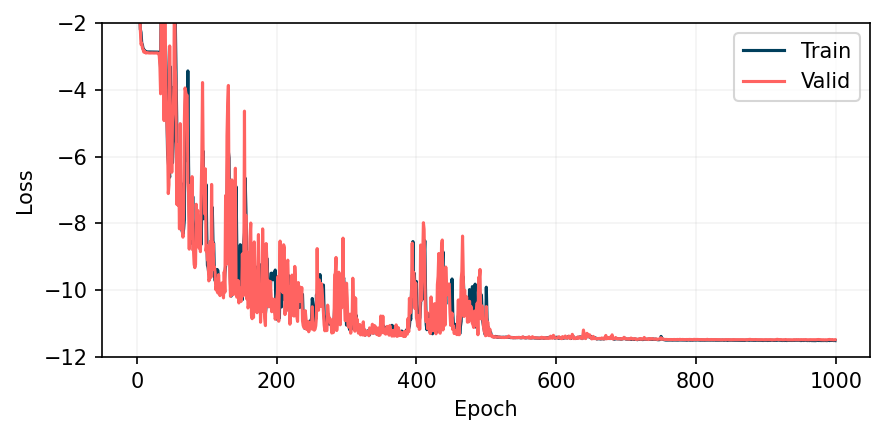

In [18]:
plt.figure(figsize=(6, 3), dpi=150)
plt.plot(train_losses, c=c0, label="Train")
plt.plot(valid_losses, c=c3, label="Valid")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.15)
plt.ylim(-12, -2)
plt.tight_layout()

plt.savefig(f"{ROOT}/results/painting-galaxies/training-logs/losses.png")

# Results on stellar mass

In [19]:
_, _, p_valid, y_valid, logvar_p = validate(valid_loader, model, device)

p_valid = p_valid.reshape((-1, 1))

p_valid.shape, y_valid.shape

((30280, 1), (30280, 1))

In [20]:
p_log_Mstar = p_valid[:, 0]

y_log_Mstar = y_valid[:, 0]

# for plotting purposes
log_Mhalo = np.concatenate([d.x[:, -2] for d in data_valid])

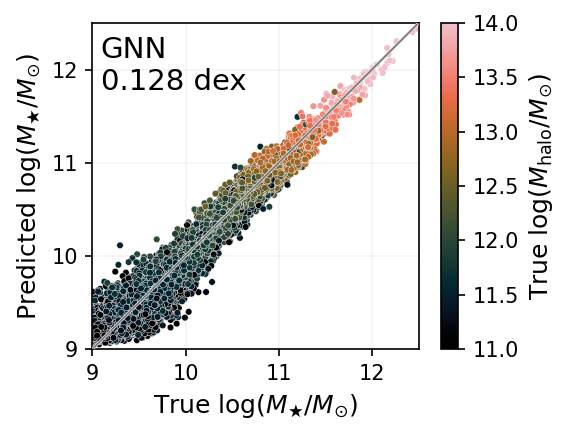

In [21]:
plt.figure(figsize=(4, 3), dpi=150)
plt.scatter(y_log_Mstar, p_log_Mstar, c=log_Mhalo, edgecolor='white', linewidths=0.2, s=10, cmap=cmr.dusk, vmin=11, vmax=14)
cb = plt.colorbar()
cb.set_label("True log($M_{\\rm halo}/M_{\\odot}}$)", fontsize=12)
plt.text(0.025, 0.96, f"GNN\n{np.sqrt(np.mean((p_log_Mstar - y_log_Mstar)**2)):.3f} dex", va="top", transform=plt.gca().transAxes, fontsize=14)
plt.plot([0, 50], [0, 50], lw=1.5, c='w', zorder=9)
plt.plot([0, 50], [0, 50], lw=1, c='0.5', zorder=10)
plt.grid(alpha=0.15)
plt.xlim(9, 12.5)
plt.ylim(9, 12.5)
plt.xticks([9, 10, 11, 12])
plt.yticks([9, 10, 11, 12])

plt.xlabel("True log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=12)
plt.ylabel("Predicted log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=12)
plt.gca().set_aspect("equal")
# plt.title("Equivariant Graph Neural Network", fontsize=14)
plt.tight_layout()

plt.savefig(f'{ROOT}/results/painting-galaxies/GNN.png')

# Comparison against ~~abundance matching~~ random forest
(used as a proxy for abundance matching with only M_halo or V_max as input and M_star as output)

In [22]:
X_train = np.concatenate([d.x[:, -1] for d in data_train]).reshape((-1, 1))
y_train = np.concatenate([d.y[:, 0] for d in data_train])

X_train.shape, y_train.shape

((163035, 1), (163035,))

In [23]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

X_valid = np.concatenate([d.x[:, -1] for d in data_valid]).reshape((-1, 1))

p_log_Mstar_rf = rf.predict(X_valid)

In [24]:
p_log_Mstar_rf.shape, y_log_Mstar.shape

((30280,), (30280,))

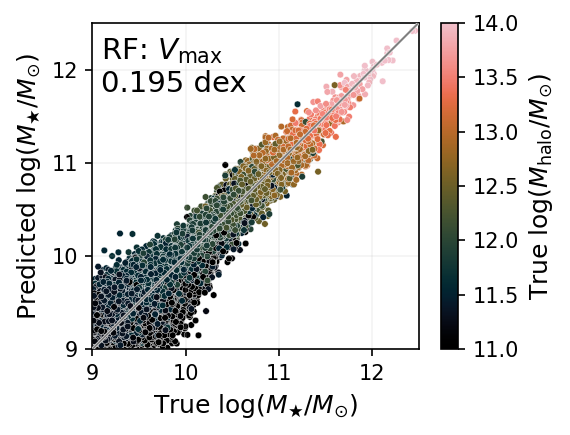

In [25]:
plt.figure(figsize=(4, 3), dpi=150)
plt.scatter(y_log_Mstar, p_log_Mstar_rf, c=log_Mhalo, edgecolor='white', linewidths=0.2, s=10, cmap=cmr.dusk, vmin=11, vmax=14)
cb = plt.colorbar()
cb.set_label("True log($M_{\\rm halo}/M_{\\odot}}$)", fontsize=12)
plt.text(0.025, 0.96, f"RF: $V_{{\\rm max}}$\n{np.sqrt(np.mean((p_log_Mstar_rf - y_log_Mstar)**2)):.3f} dex", va="top", transform=plt.gca().transAxes, fontsize=14)

plt.plot([0, 50], [0, 50], lw=1.5, c='w', zorder=9)
plt.plot([0, 50], [0, 50], lw=1, c='0.5', zorder=10)
plt.grid(alpha=0.15)
plt.xlim(9, 12.5)
plt.ylim(9, 12.5)
plt.xticks([9, 10, 11, 12])
plt.yticks([9, 10, 11, 12])

plt.xlabel("True log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=12)
plt.ylabel("Predicted log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=12)
plt.gca().set_aspect("equal")
# plt.title("$V_{\\rm max}$ Subhalo Abundance Matching", fontsize=14)
plt.tight_layout()

plt.savefig(f'{ROOT}/results/painting-galaxies/rf-Vmax.png')

In [26]:
X_train_Mh = np.concatenate([d.x[:, -2] for d in data_train]).reshape((-1, 1))
y_train = np.concatenate([d.y[:, 0] for d in data_train])

rf_Mh = RandomForestRegressor()
rf_Mh.fit(X_train_Mh, y_train)

X_valid_Mh = np.concatenate([d.x[:, -2] for d in data_valid]).reshape((-1, 1))

p_log_Mstar_rf_Mh = rf_Mh.predict(X_valid_Mh)

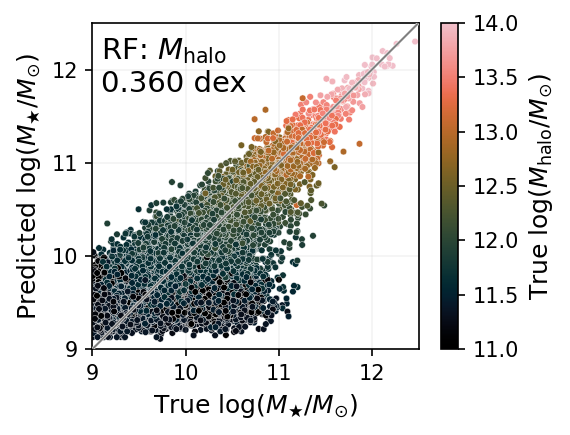

In [27]:
plt.figure(figsize=(4, 3), dpi=150)
plt.scatter(y_log_Mstar, p_log_Mstar_rf_Mh, c=log_Mhalo, edgecolor='white', linewidths=0.2, s=10, cmap=cmr.dusk, vmin=11, vmax=14)
cb = plt.colorbar()
cb.set_label("True log($M_{\\rm halo}/M_{\\odot}}$)", fontsize=12)
plt.text(0.025, 0.96, f"RF: $M_{{\\rm halo}}$\n{np.sqrt(np.mean((p_log_Mstar_rf_Mh - y_log_Mstar)**2)):.3f} dex", va="top", transform=plt.gca().transAxes, fontsize=14)

plt.plot([0, 50], [0, 50], lw=1.5, c='w', zorder=9)
plt.plot([0, 50], [0, 50], lw=1, c='0.5', zorder=10)
plt.grid(alpha=0.15)
plt.xlim(9, 12.5)
plt.ylim(9, 12.5)
plt.xticks([9, 10, 11, 12])
plt.yticks([9, 10, 11, 12])

plt.xlabel("True log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=12)
plt.ylabel("Predicted log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=12)
plt.gca().set_aspect("equal")
# plt.title("$M_{\\rm halo}$ Subhalo Abundance Matching", fontsize=14)

plt.tight_layout()

plt.savefig(f'{ROOT}/results/painting-galaxies/rf-Mhalo.png')

# Combined SHAM with both Vmax and Mhalo

In [28]:
X_train_combined = np.concatenate([d.x[:, -2:] for d in data_train]).reshape((-1, 2))
y_train = np.concatenate([d.y[:, 0] for d in data_train])

rf_combined = RandomForestRegressor()
rf_combined.fit(X_train_combined, y_train)

X_valid_combined = np.concatenate([d.x[:, -2:] for d in data_valid]).reshape((-1, 2))

p_log_Mstar_rf_combined = rf_combined.predict(X_valid_combined)

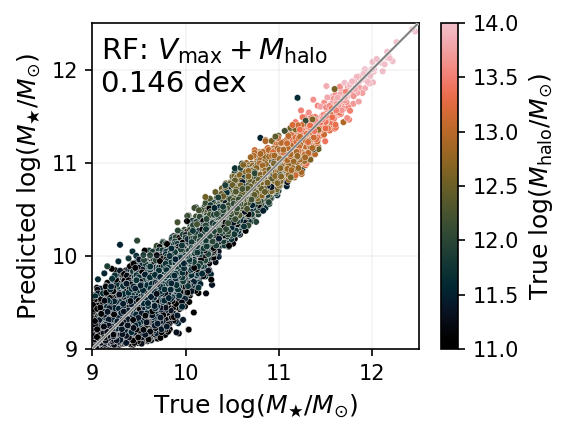

In [29]:
plt.figure(figsize=(4, 3), dpi=150)
plt.scatter(y_log_Mstar, p_log_Mstar_rf_combined, c=log_Mhalo, edgecolor='white', linewidths=0.2, s=10, cmap=cmr.dusk, vmin=11, vmax=14)
cb = plt.colorbar()
cb.set_label("True log($M_{\\rm halo}/M_{\\odot}}$)", fontsize=12)
plt.text(0.025, 0.96, f"RF: $V_{{\\rm max}}+M_{{\\rm halo}}$\n{np.sqrt(np.mean((p_log_Mstar_rf_combined - y_log_Mstar)**2)):.3f} dex", va="top", transform=plt.gca().transAxes, fontsize=14)

plt.plot([0, 50], [0, 50], lw=1.5, c='w', zorder=9)
plt.plot([0, 50], [0, 50], lw=1, c='0.5', zorder=10)
plt.grid(alpha=0.15)
plt.xlim(9, 12.5)
plt.ylim(9, 12.5)
plt.xticks([9, 10, 11, 12])
plt.yticks([9, 10, 11, 12])

plt.xlabel("True log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=12)
plt.ylabel("Predicted log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=12)
plt.gca().set_aspect("equal")
# plt.title("$V_{\\rm max}$ + $M_{\\rm halo}$ SHAM", fontsize=14)

plt.tight_layout()

plt.savefig(f'{ROOT}/results/painting-galaxies/rf-Mhalo+Vmax.png')

# Save results and make Multi-figure

In [30]:
import pandas as pd

df = pd.DataFrame({
        "log_Mhalo": X_valid_combined[:, 0],
        "log_Vmax": X_valid_combined[:, 1],
        "log_Mstar": y_log_Mstar,
        "p_RF_Mhalo": p_log_Mstar_rf_Mh,
        "p_RF_Vmax": p_log_Mstar_rf,
        "p_RF_combined": p_log_Mstar_rf_combined,
        "p_GNN_3d": p_log_Mstar
})

df.to_csv(f"{ROOT}/results/painting-galaxies/validation.csv", index=False)

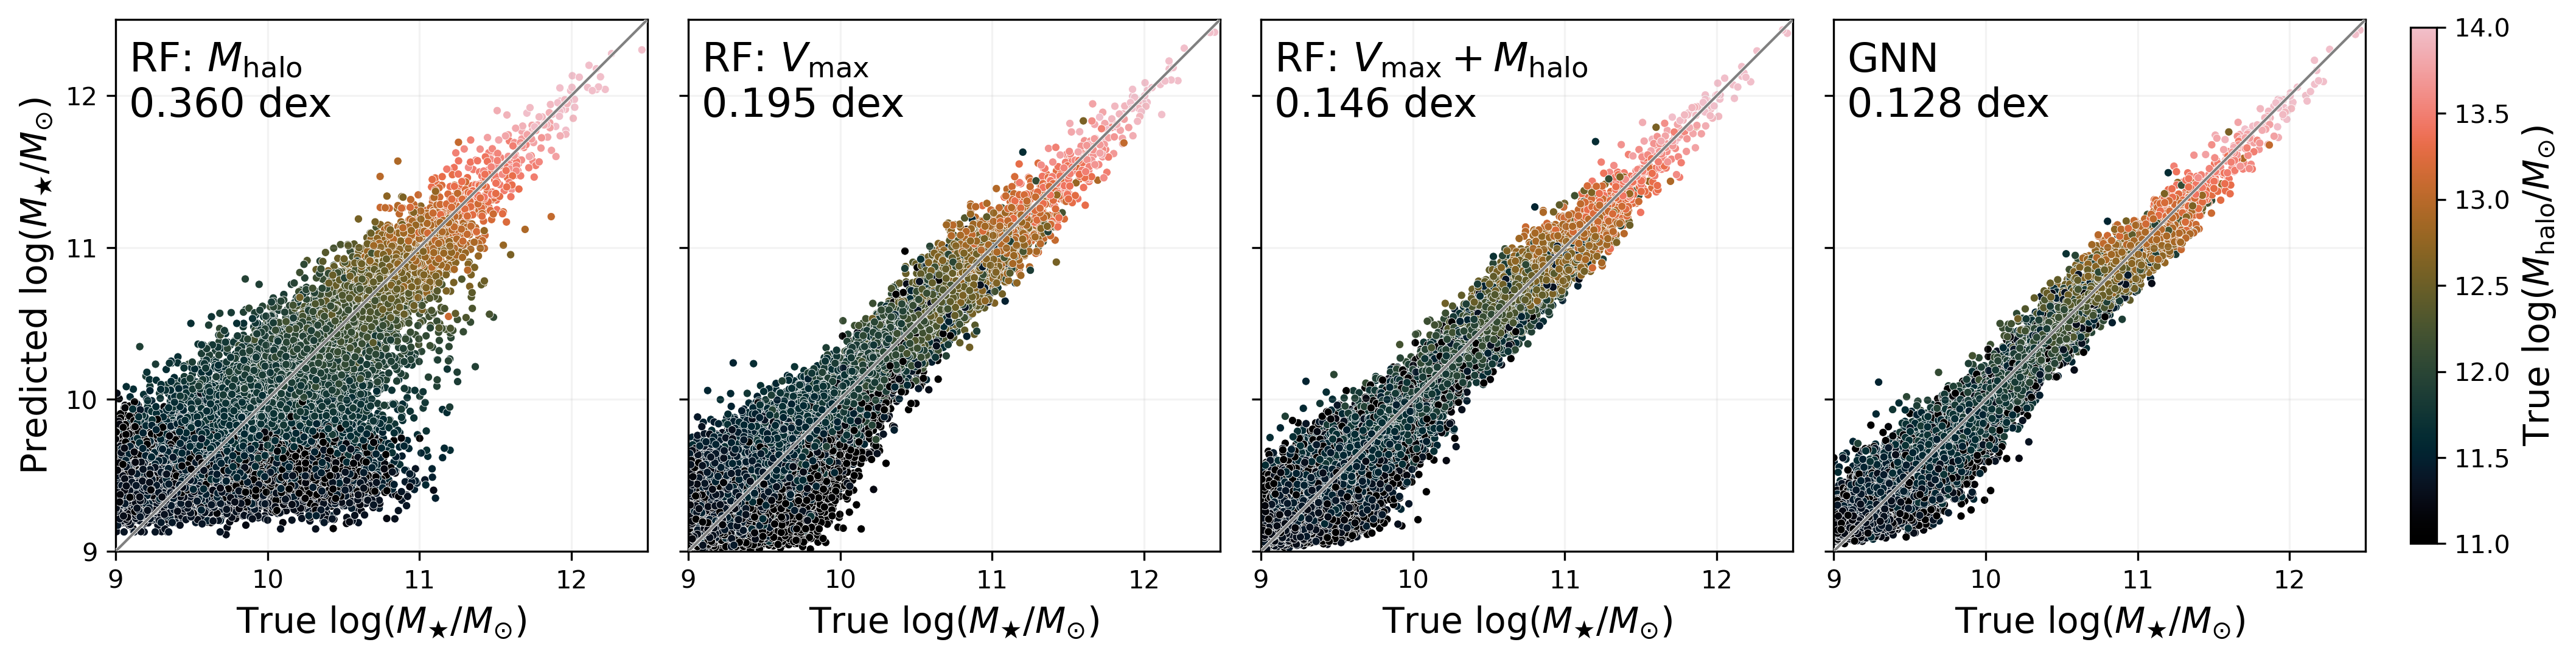

In [31]:
fig = plt.figure(figsize=(14, 3.75), dpi=300, constrained_layout=True)
gs = fig.add_gridspec(1, 4, wspace=0.05, left=0.05, right=0.95, bottom=0.025, top=0.975, )
ax1, ax2, ax3, ax4 = gs.subplots(sharey="row")

ax1.scatter(y_log_Mstar, p_log_Mstar_rf_Mh, c=log_Mhalo, edgecolor='white', linewidths=0.2, s=10, cmap=cmr.dusk, vmin=11, vmax=14)
ax1.text(0.025, 0.96, f"RF: $M_{{\\rm halo}}$\n{np.sqrt(np.mean((p_log_Mstar_rf_Mh - y_log_Mstar)**2)):.3f} dex", va="top", transform=ax1.transAxes, fontsize=16)

ax2.scatter(y_log_Mstar, p_log_Mstar_rf, c=log_Mhalo, edgecolor='white', linewidths=0.2, s=10, cmap=cmr.dusk, vmin=11, vmax=14)
ax2.text(0.025, 0.96, f"RF: $V_{{\\rm max}}$\n{np.sqrt(np.mean((p_log_Mstar_rf - y_log_Mstar)**2)):.3f} dex", va="top", transform=ax2.transAxes, fontsize=16)

ax3.scatter(y_log_Mstar, p_log_Mstar_rf_combined, c=log_Mhalo, edgecolor='white', linewidths=0.2, s=10, cmap=cmr.dusk, vmin=11, vmax=14)
ax3.text(0.025, 0.96, f"RF: $V_{{\\rm max}}+M_{{\\rm halo}}$\n{np.sqrt(np.mean((p_log_Mstar_rf_combined - y_log_Mstar)**2)):.3f} dex", va="top", transform=ax3.transAxes, fontsize=16)

sc = ax4.scatter(y_log_Mstar, p_log_Mstar, c=log_Mhalo, edgecolor='white', linewidths=0.2, s=10, cmap=cmr.dusk, vmin=11, vmax=14)
ax4.text(0.025, 0.96, f"GNN\n{np.sqrt(np.mean((p_log_Mstar - y_log_Mstar)**2)):.3f} dex", va="top", transform=ax4.transAxes, fontsize=16)

cb = fig.colorbar(sc, ax=[ax1, ax2, ax3, ax4], pad=0.02, shrink=0.83)
cb.set_label("True log($M_{\\rm halo}/M_{\\odot}}$)", fontsize=14)


for ax in [ax1, ax2, ax3, ax4]:
    ax.plot([0, 50], [0, 50], lw=1.5, c='w', zorder=9)
    ax.plot([0, 50], [0, 50], lw=1, c='0.5', zorder=10)
    ax.grid(alpha=0.15)
    ax.set_xlim(9, 12.5)
    ax.set_ylim(9, 12.5)
    ax.set_xticks([9, 10, 11, 12])
    ax.set_yticks([9, 10, 11, 12])

    if ax == ax1:
        ax.set_ylabel("Predicted log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=14)
    ax.set_xlabel("True log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=14)
    ax.set_aspect("equal")


plt.savefig(f'{ROOT}/results/painting-galaxies/GNN-vs-RF.png')

# Multiple metrics

In [47]:
from scipy.stats import median_abs_deviation
def get_metrics(p, y):
    rmse = np.sqrt(np.mean((p-y)**2))
    nmad = median_abs_deviation((p-y), scale="normal")
    mae = np.mean(np.absolute(p-y))
    pearson_rho = np.corrcoef(p, y)[0,1]
    r2 = 1 - (np.sum((p-y)**2) / np.sum((y - y.mean())**2))
    bias = np.mean(p - y)*1e3
    f_outlier = np.mean(np.absolute(p-y) > 3*nmad) * 100

    return rmse, nmad, mae, pearson_rho, r2, bias, f_outlier

In [48]:
metrics_Mh = get_metrics(df.p_RF_Mhalo, df.log_Mstar)
print("RF - $M_{\\rm halo}$ & 1 & " + " & ".join([f"{m:.3f}" for m in metrics_Mh]) + "\\\\")

metrics_Vmax = get_metrics(df.p_RF_Vmax, df.log_Mstar)
print("RF - $V_{\\rm max}$ & 1 & " + " & ".join([f"{m:.3f}" for m in metrics_Vmax]) + "\\\\")

metrics_combined = get_metrics(df.p_RF_combined, df.log_Mstar)
print("RF - $M_{\\rm halo}+V_{\\rm max}$ & 2 & " + " & ".join([f"{m:.3f}" for m in metrics_combined]) + "\\\\")

metrics_GNN = get_metrics(df.p_GNN_3d, df.log_Mstar)
print("\\bf GNN & \\bf 8 & \\bf " + " & \\bf ".join([f"{m:.3f}" for m in metrics_GNN]) + "\\\\")

RF - $M_{\rm halo}$ & 1 & 0.360 & 0.303 & 0.273 & 0.784 & 0.612 & 7.945 & 2.470\\
RF - $V_{\rm max}$ & 1 & 0.195 & 0.177 & 0.150 & 0.942 & 0.887 & 4.707 & 1.298\\
RF - $M_{\rm halo}+V_{\rm max}$ & 2 & 0.146 & 0.136 & 0.113 & 0.967 & 0.936 & 2.390 & 1.129\\
\bf GNN & \bf 8 & \bf 0.128 & \bf 0.124 & \bf 0.101 & \bf 0.975 & \bf 0.951 & \bf -0.895 & \bf 0.575\\


# in **projection**

In [34]:
in_projection = True
proj_str = "-projected" if in_projection else ""
data_path = osp.join(tng_base_path, 'cosmic_graphs', f'split_{split**3}_link_{int(r_link)}_pad{int(pad)}_gal{int(use_gal)}{proj_str}.pkl')


if osp.isfile(data_path) and not reload:
    print('File already exists')
else:
    print('Remaking dataset')
    make_webs(tng_base_path=tng_base_path, snapshot=snapshot, r_link = r_link, pad = pad, split=split, \
              cuts = cuts, use_gal = use_gal, h = h, undirected = undirected, periodic = periodic,\
              use_loops = use_loops, in_projection=in_projection)
    
print(data_path)
data = pickle.load(open(data_path, 'rb'))


Remaking dataset


/home/john/miniconda3/envs/pyg/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_7669/2669803001.py:158: RuntimeWarning: invalid value encountered in divide
  unitdiff = diff/dist.reshape(-1,1)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

/home/john/research/halo-gnns/illustris_data/TNG300-1/output/cosmic_graphs/split_216_link_5_pad2_gal0-projected.pkl


In [51]:
import gc; gc.collect()

6773

In [36]:

node_features = data[0].x.shape[1]
out_features = data[0].y.shape[1]

model = EdgePointGNN(
    node_features=node_features, 
    n_layers=1, 
    D_link=5,
    hidden_channels=n_hidden,
    latent_channels=n_latent,
    loop=use_loops,
    estimate_all_subhalos=True,
    use_global_pooling=False,
    n_out=out_features,
    aggr=aggr
)

model.to(device)


EdgePointGNN(
  (layers): ModuleList(
    (0): EdgePointLayer()
  )
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [37]:
from train import *

batch_size = 36

data_train = data[:-train_test_frac_split]
data_valid = data[-train_test_frac_split:]

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=batch_size, shuffle=False)


In [38]:
training_params = dict(
    batch_size=batch_size,
    learning_rate=1e-2,
    weight_decay=1e-4,
    n_epochs=1000,
)

optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=training_params["learning_rate"], 
    weight_decay=training_params["weight_decay"]
)


train_losses = []
valid_losses = []
for epoch in range(training_params["n_epochs"]):

    # anneal 
    if (epoch == 500):
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=training_params["learning_rate"] / 5, 
            weight_decay=training_params["weight_decay"] / 5
        )
    elif (epoch == 750):
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=training_params["learning_rate"] / 25, 
            weight_decay=training_params["weight_decay"] / 25
        )

    train_loss = train(train_loader, model, optimizer, device, in_projection=in_projection)
    valid_loss, valid_std, p, y, logvar_p  = validate(valid_loader, model, device, in_projection=in_projection)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
   
    if (epoch + 1) % 10 == 0:
        print(f" {epoch + 1: >4d}      {train_loss: >6.2f}       {valid_loss: >6.2f}    {np.sqrt(np.mean((p - y.flatten())**2)): >6.3f}  {np.mean(valid_std): >6.3f}")



   10       -2.83        -2.83     0.610   0.662
   20       -2.97        -3.23     0.566   0.581
   30       -4.97        -6.41     0.280   0.275
   40       -6.18        -4.49     0.448   0.199
   50       -8.69        -8.63     0.206   0.209
   60       -8.75        -9.34     0.182   0.185
   70       -7.92        -9.17     0.191   0.201
   80       -8.46        -9.25     0.180   0.254
   90       -8.02        -7.93     0.245   0.168
  100      -10.21       -10.57     0.151   0.139
  110       -8.53       -10.09     0.171   0.165
  120       -9.72        -9.84     0.176   0.164
  130      -10.60       -10.04     0.165   0.137
  140      -10.08        -8.20     0.231   0.169
  150      -10.75       -10.66     0.149   0.145
  160      -10.70        -9.95     0.168   0.143
  170      -10.48       -10.51     0.153   0.159
  180       -9.31       -10.58     0.155   0.154
  190      -10.59       -10.31     0.162   0.148
  200      -10.52       -10.93     0.142   0.156
  210      -10.48   

In [54]:
torch.save(
    model.state_dict(),
    f"{ROOT}/models/EdgePointGNN-projection-link{r_link}-hidden{n_hidden}-latent{n_latent}-selfloops{int(use_loops)}-agg{aggr}-epochs{training_params['n_epochs']}.pth", 
)

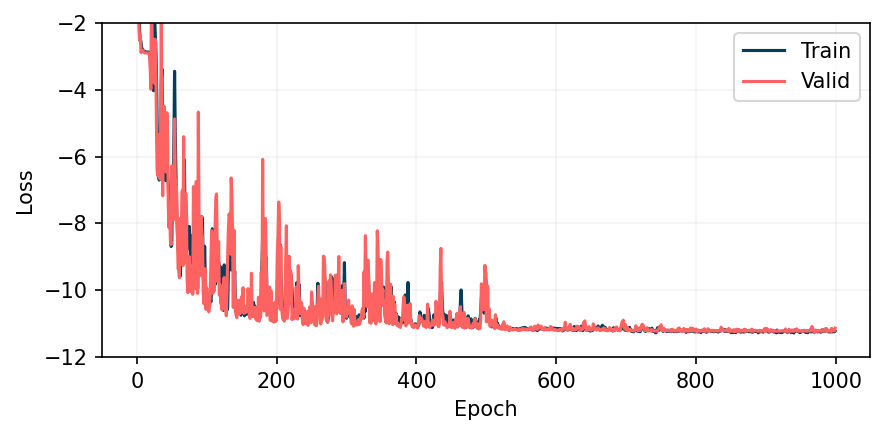

In [55]:
plt.figure(figsize=(6, 3), dpi=150)
plt.plot(train_losses, c=c0, label="Train")
plt.plot(valid_losses, c=c3, label="Valid")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.15)
plt.ylim(-12, -2)

plt.tight_layout()

plt.savefig(f"{ROOT}/results/painting-galaxies/training-logs/losses-projection.png")

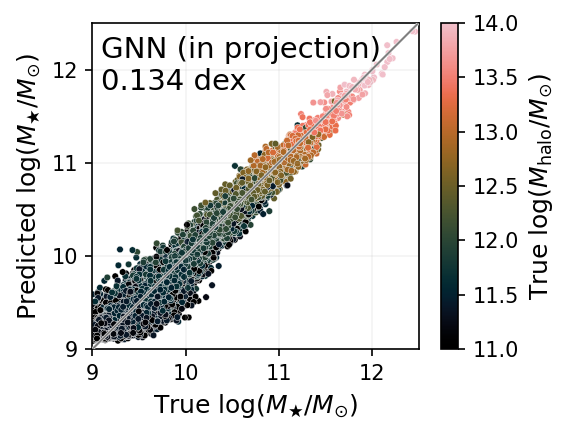

In [56]:
_, _, p_valid, y_valid, logvar_p = validate(valid_loader, model, device, in_projection=True)

p_valid = p_valid.reshape((-1, 1))

p_log_Mstar_proj = p_valid[:, 0]
y_log_Mstar = y_valid[:, 0]

# for plotting purposes
log_Mhalo = np.concatenate([d.x[:, -2] for d in data_valid])

plt.figure(figsize=(4, 3), dpi=150)
plt.scatter(y_log_Mstar, p_log_Mstar_proj, c=log_Mhalo, edgecolor='white', linewidths=0.2, s=10, cmap=cmr.dusk, vmin=11, vmax=14)
cb = plt.colorbar()
cb.set_label("True log($M_{\\rm halo}/M_{\\odot}}$)", fontsize=12)
plt.text(0.025, 0.96, f"GNN (in projection)\n{np.sqrt(np.mean((p_log_Mstar_proj - y_log_Mstar)**2)):.3f} dex", va="top", transform=plt.gca().transAxes, fontsize=14)
plt.plot([0, 50], [0, 50], lw=1.5, c='w', zorder=9)
plt.plot([0, 50], [0, 50], lw=1, c='0.5', zorder=10)
plt.grid(alpha=0.15)
plt.xlim(9, 12.5)
plt.ylim(9, 12.5)
plt.xticks([9, 10, 11, 12])
plt.yticks([9, 10, 11, 12])

plt.xlabel("True log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=12)
plt.ylabel("Predicted log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=12)
plt.gca().set_aspect("equal")
# plt.title("Equivariant Graph Neural Network", fontsize=14)
plt.tight_layout()

plt.savefig(f'{ROOT}/results/painting-galaxies/GNN-projection.png')

In [57]:
metrics_combined = get_metrics(p_log_Mstar_proj, y_log_Mstar)
print("GNN (projection) & 5 & " + " & ".join([f"{m:.3f}" for m in metrics_combined]) + "\\\\")

GNN (projection) & 5 & 0.134 & 0.130 & 0.106 & 0.973 & 0.946 & -9.399 & 0.647\\


In [58]:
# df = pd.read_csv(f"{ROOT}/results/painting-galaxies/validation.csv")

# df["p_GNN_2d"] = p_log_Mstar_proj

# df.to_csv(f"{ROOT}/results/painting-galaxies/validation.csv", index=False)

In [72]:
metrics_Mh = get_metrics(df.p_RF_Mhalo, df.log_Mstar)
print("RF - $M_{\\rm halo}$ & 1 & " + " & ".join([f"{m:.3f}" for m in metrics_Mh]) + "\\\\")

metrics_Vmax = get_metrics(df.p_RF_Vmax, df.log_Mstar)
print("RF - $V_{\\rm max}$ & 1 & " + " & ".join([f"{m:.3f}" for m in metrics_Vmax]) + "\\\\")

metrics_combined = get_metrics(df.p_RF_combined, df.log_Mstar)
print("RF - $M_{\\rm halo}+V_{\\rm max}$ & 2 & " + " & ".join([f"{m:.3f}" for m in metrics_combined]) + "\\\\")

metrics_GNN_proj = get_metrics(df.p_GNN_2d, df.log_Mstar)
print("GNN ($2d$ projection) & 5 & " + " & ".join([f"{m:.3f}" for m in metrics_GNN_proj]) + "\\\\")

metrics_GNN = get_metrics(df.p_GNN_3d, df.log_Mstar)
print("\\bf GNN ($\\bm{(3d)}$) & 8 & \\bf " + " & \\bf ".join([f"{m:.3f}" for m in metrics_GNN]) + "\\\\")

RF - $M_{\rm halo}$ & 1 & 0.360 & 0.303 & 0.273 & 0.784 & 0.612 & 7.945 & 2.470\\
RF - $V_{\rm max}$ & 1 & 0.195 & 0.177 & 0.150 & 0.942 & 0.887 & 4.707 & 1.298\\
RF - $M_{\rm halo}+V_{\rm max}$ & 2 & 0.146 & 0.136 & 0.113 & 0.967 & 0.936 & 2.390 & 1.129\\
GNN ($2d$ projection) & 5 & 0.134 & 0.130 & 0.106 & 0.973 & 0.946 & -9.399 & 0.647\\
\bf GNN ($\bm{(3d)}$) & 8 & \bf 0.128 & \bf 0.124 & \bf 0.101 & \bf 0.975 & \bf 0.951 & \bf -0.895 & \bf 0.575\\


# satellites vs centrals (3d case)


In [129]:
tng_base_path = "../illustris_data/TNG300-1/output"
snapshot = 99

subhalo_fields = [
        "SubhaloPos", "SubhaloMassType", "SubhaloLenType", "SubhaloHalfmassRadType", 
        "SubhaloVel", "SubhaloVmax", "SubhaloGrNr", "SubhaloFlag"
    ]
subhalos = il.groupcat.loadSubhalos(tng_base_path, snapshot, fields=subhalo_fields) 

pos = subhalos["SubhaloPos"][:,:3]
min_box, max_box = np.rint(np.min(pos)), np.rint(np.max(pos))

box_size = max_box/(h*1e3) # in Mpc


halo_fields = ["Group_M_Crit200", "GroupFirstSub", "GroupPos", "GroupVel"]
halos = il.groupcat.loadHalos(tng_base_path, snapshot, fields=halo_fields)

halo_fields = ["Group_M_Crit200", "GroupFirstSub", "GroupPos", "GroupVel"]
halos = il.groupcat.loadHalos(tng_base_path, snapshot, fields=halo_fields)

subhalo_pos = subhalos["SubhaloPos"][:] / (h*1e3)
subhalo_stellarmass = subhalos["SubhaloMassType"][:,4]
subhalo_halomass = subhalos["SubhaloMassType"][:,1]
subhalo_n_stellar_particles = subhalos["SubhaloLenType"][:,4]
subhalo_stellarhalfmassradius = subhalos["SubhaloHalfmassRadType"][:,4]  / normalization_params["norm_half_mass_radius"]
subhalo_vel = subhalos["SubhaloVel"][:] /  normalization_params["norm_velocity"]
subhalo_vmax = subhalos["SubhaloVmax"][:] / normalization_params["norm_velocity"]
subhalo_flag = subhalos["SubhaloFlag"][:]
halo_id = subhalos["SubhaloGrNr"][:].astype(int)

halo_mass = halos["Group_M_Crit200"][:]
halo_primarysubhalo = halos["GroupFirstSub"][:].astype(int)
group_pos = halos["GroupPos"][:] / (h*1e3)
group_vel = halos["GroupVel"][:]  / normalization_params["norm_velocity"]

halos = pd.DataFrame(
    np.column_stack((np.arange(len(halo_mass)), group_pos, group_vel, halo_mass, halo_primarysubhalo)),
    columns=['halo_id', 'halo_x', 'halo_y', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_mass', 'halo_primarysubhalo']
)
halos['halo_id'] = halos['halo_id'].astype(int)
halos.set_index("halo_id", inplace=True)

# get subhalos/galaxies      
subhalos = pd.DataFrame(
    np.column_stack([halo_id, subhalo_flag, np.arange(len(subhalo_stellarmass)), subhalo_pos, subhalo_vel, subhalo_n_stellar_particles, subhalo_stellarmass, subhalo_halomass, subhalo_stellarhalfmassradius, subhalo_vmax]), 
    columns=['halo_id', 'subhalo_flag', 'subhalo_id', 'subhalo_x', 'subhalo_y', 'subhalo_z', 'subhalo_vx', 'subhalo_vy', 'subhalo_vz', 'subhalo_n_stellar_particles', 'subhalo_stellarmass', 'subhalo_halomass', 'subhalo_stellarhalfmassradius', 'subhalo_vmax'],
)
subhalos["is_central"] = (halos.loc[subhalos.halo_id]["halo_primarysubhalo"].values == subhalos["subhalo_id"].values)

subhalos = subhalos[subhalos["subhalo_flag"] != 0].copy()
subhalos['halo_id'] = subhalos['halo_id'].astype(int)
subhalos['subhalo_id'] = subhalos['subhalo_id'].astype(int)

subhalos.drop("subhalo_flag", axis=1, inplace=True)

# impose stellar mass and particle cuts
subhalos = subhalos[subhalos["subhalo_n_stellar_particles"] > cuts["minimum_n_star_particles"]].copy()
subhalos["subhalo_logstellarmass"] = np.log10(subhalos["subhalo_stellarmass"] / h)+10

subhalos["subhalo_loghalomass"] = np.log10(subhalos["subhalo_halomass"] / h)+10
subhalos["subhalo_logvmax"] = np.log10(subhalos["subhalo_vmax"])
subhalos["subhalo_logstellarhalfmassradius"] = np.log10(subhalos["subhalo_stellarhalfmassradius"])

subhalos = subhalos[subhalos["subhalo_loghalomass"] > cuts["minimum_log_halo_mass"]].copy()

subhalos = subhalos[subhalos["subhalo_logstellarmass"] > cuts["minimum_log_stellar_mass"]].copy()

# subhalos.reset_index(drop=True)

/home/john/miniconda3/envs/pyg/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


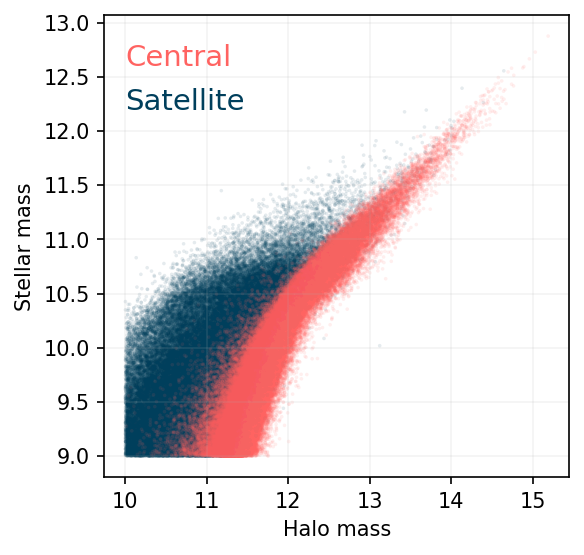

In [149]:
sc_kwargs = dict(s=3, edgecolor="none", alpha=0.1)

plt.figure(figsize=(4,4), dpi=150)
plt.scatter(subhalos.subhalo_loghalomass, subhalos.subhalo_logstellarmass, c=np.where(subhalos.is_central, c3, c0), **sc_kwargs)
plt.text(10, 12.6, "Central", color=c3, fontsize=14)
plt.text(10, 12.2, "Satellite", color=c0, fontsize=14)
plt.xlabel("Halo mass")
plt.ylabel("Stellar mass")
plt.grid(alpha=0.15)

In [153]:
use_cols = ['subhalo_x', 'subhalo_y', 'subhalo_z', 'subhalo_vx', 'subhalo_vy', 'subhalo_vz', 'subhalo_loghalomass', 'subhalo_logvmax'] 
y_cols = ['subhalo_logstellarmass']

data = []
for n in tqdm(range(split), position=0):
    for g in tqdm(range(split), position=1, leave=False):
        for k in tqdm(range(split), position=2, leave=False):
            # print(n,g,k)
            xlims = np.array([box_size/split*n+pad, box_size/split*(n+1)-pad])
            ylims = np.array([box_size/split*g+pad, box_size/split*(g+1)-pad])
            zlims = np.array([box_size/split*k+pad, box_size/split*(k+1)-pad])

            pos = np.vstack(subhalos[['subhalo_x', 'subhalo_y', 'subhalo_z']].to_numpy())

            xmask = np.logical_and(pos[:,0]>xlims[0],pos[:,0]<xlims[1])
            ymask = np.logical_and(pos[:,1]>ylims[0],pos[:,1]<ylims[1])
            zmask = np.logical_and(pos[:,2]>zlims[0],pos[:,2]<zlims[1])
            mask = np.logical_and(zmask, np.logical_and(xmask, ymask))

            df = subhalos.iloc[mask].copy()
            df.reset_index(drop=True)

            # remove extraneous columns
            df.drop(["subhalo_n_stellar_particles", "subhalo_stellarmass", "subhalo_halomass"], axis=1, inplace=True)

            # set new zero point

            df[['subhalo_x', 'subhalo_y', 'subhalo_z']] = df[['subhalo_x', 'subhalo_y', 'subhalo_z']] - np.array([box_size/split*n+pad, box_size/split*g+pad, box_size/split*k+pad])

            #make positions for clustering
            
            if in_projection:
                pos = np.vstack(df[['subhalo_x', 'subhalo_y']].to_numpy())    
            else:
                pos = np.vstack(df[['subhalo_x', 'subhalo_y', 'subhalo_z']].to_numpy())

            kd_tree = ss.KDTree(pos, leafsize=25, boxsize=box_size)
            edge_index = kd_tree.query_pairs(r=r_link, output_type="ndarray")

            # normalize positions

            df[['subhalo_x', 'subhalo_y', 'subhalo_z']] = df[['subhalo_x', 'subhalo_y', 'subhalo_z']]/(box_size/2)

            if undirected:
            # Add reverse pairs
                reversepairs = np.zeros((edge_index.shape[0],2))
                for i, pair in enumerate(edge_index):
                    reversepairs[i] = np.array([pair[1], pair[0]])
                edge_index = np.append(edge_index, reversepairs, 0)

                edge_index = edge_index.astype(int)

                # Write in pytorch-geometric format
                edge_index = edge_index.reshape((2,-1))
                num_pairs = edge_index.shape[1]

            row, col = edge_index

            diff = pos[row]-pos[col]
            dist = np.linalg.norm(diff, axis=1)

            if periodic:
                # Take into account periodic boundary conditions, correcting the distances
                for i, pos_i in enumerate(diff):
                    for j, coord in enumerate(pos_i):
                        if coord > r_link:
                            diff[i,j] -= box_size  # Boxsize normalize to 1
                        elif -coord > r_link:
                            diff[i,j] += box_size  # Boxsize normalize to 1

            centroid = np.mean(pos,axis=0) # define arbitrary coordinate, invarinat to translation/rotation shifts, but not stretches
            # centroid+=1.2

            unitrow = (pos[row]-centroid)/np.linalg.norm((pos[row]-centroid), axis=1).reshape(-1,1)
            unitcol = (pos[col]-centroid)/np.linalg.norm((pos[col]-centroid), axis=1).reshape(-1,1)
            unitdiff = diff/dist.reshape(-1,1)
            # Dot products between unit vectors
            cos1 = np.array([np.dot(unitrow[i,:].T,unitcol[i,:]) for i in range(num_pairs)])
            cos2 = np.array([np.dot(unitrow[i,:].T,unitdiff[i,:]) for i in range(num_pairs)])

            edge_attr = np.concatenate([dist.reshape(-1,1), cos1.reshape(-1,1), cos2.reshape(-1,1)], axis=1)

            if use_loops:
                loops = np.zeros((2,pos.shape[0]),dtype=int)
                atrloops = np.zeros((pos.shape[0],3))
                for i, posit in enumerate(pos):
                    loops[0,i], loops[1,i] = i, i
                    atrloops[i,0], atrloops[i,1], atrloops[i,2] = 0., 1., 0.
                edge_index = np.append(edge_index, loops, 1)
                edge_attr = np.append(edge_attr, atrloops, 0)
            edge_index = edge_index.astype(int)

            x = torch.tensor(np.vstack(df[use_cols].to_numpy()), dtype=torch.float)
            y = torch.tensor(np.vstack(df[y_cols].to_numpy()), dtype=torch.float)
            edge_index = torch.tensor(edge_index, dtype=torch.long)
            edge_attr=torch.tensor(edge_attr, dtype=torch.float)
            pos = torch.tensor(pos, dtype=torch.float)
            is_central = torch.tensor(df.is_central.values, dtype=bool)

            data.append(Data(x=x, y=y, pos=pos, is_central=is_central, edge_index=edge_index, edge_attr=edge_attr))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_7669/395899958.py:76: RuntimeWarning: invalid value encountered in divide
  unitdiff = diff/dist.reshape(-1,1)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [154]:
# data_path = osp.join(tng_base_path, 'cosmic_graphs', f'split_{split**3}_link_{int(r_link)}_pad{int(pad)}_gal{int(use_gal)}{proj_str}-centrals_satellites.pkl')
# with open(data_path, 'wb') as handle:
#     pickle.dump(data, handle)

In [160]:
import gc; gc.collect()

148

In [159]:
# load trained model and evaluate on data
data_path = osp.join(tng_base_path, 'cosmic_graphs', f'split_{split**3}_link_{int(r_link)}_pad{int(pad)}_gal{int(use_gal)}{proj_str}-centrals_satellites.pkl')
data = pickle.load(open(data_path, 'rb'))

node_features = data[0].x.shape[1]
out_features = data[0].y.shape[1]

n_hidden = 256
n_latent = 128

model = EdgePointGNN(
    node_features=node_features, 
    n_layers=1, 
    D_link=5,
    hidden_channels=n_hidden,
    latent_channels=n_latent,
    loop=use_loops,
    estimate_all_subhalos=True,
    use_global_pooling=False,
    n_out=out_features,
    aggr=aggr
)

model.to(device)
model.load_state_dict(torch.load(f"{ROOT}/models/painting-galaxies/EdgePointGNN-link{r_link}-hidden{n_hidden}-latent{n_latent}-selfloops{int(use_loops)}-agg{aggr}-epochs{training_params['n_epochs']}.pth", ));

In [161]:
batch_size = 36

data_train = data[:-train_test_frac_split]
data_valid = data[-train_test_frac_split:]

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=batch_size, shuffle=False)

In [168]:
_, _, p_valid, y_valid, logvar_p = validate(valid_loader, model, device)

p_valid = p_valid.reshape((-1, 1))

p_log_Mstar = p_valid[:, 0]
y_log_Mstar = y_valid[:, 0]

# for plotting purposes
log_Mhalo = np.concatenate([d.x[:, -2] for d in data_valid])
is_central = np.concatenate([d.is_central for d in data_valid])

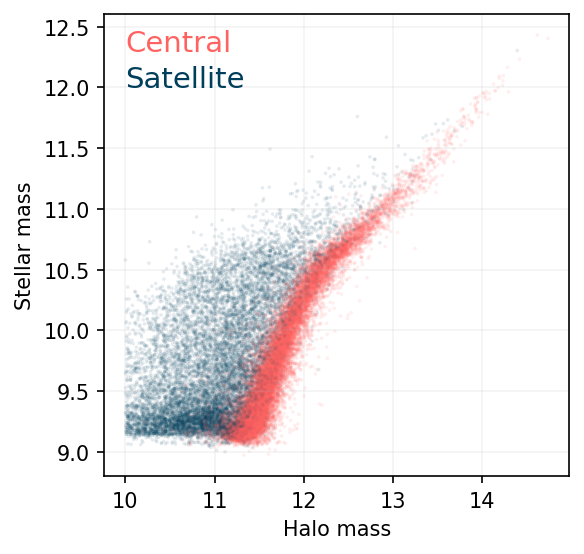

In [171]:
# sanity check
sc_kwargs = dict(s=3, edgecolor="none", alpha=0.1)

plt.figure(figsize=(4,4), dpi=150)
plt.scatter(log_Mhalo, p_log_Mstar, c=np.where(is_central, c3, c0), **sc_kwargs)
plt.text(10, 12.3, "Central", color=c3, fontsize=14)
plt.text(10, 12., "Satellite", color=c0, fontsize=14)
plt.xlabel("Halo mass")
plt.ylabel("Stellar mass")
plt.grid(alpha=0.15)

In [172]:
# df = pd.read_csv(f"{ROOT}/results/painting-galaxies/validation.csv")

# df["is_central"] = is_central

# df.to_csv(f"{ROOT}/results/painting-galaxies/validation.csv", index=False)

# Examine residual plots

In [173]:
from scipy.stats import binned_statistic

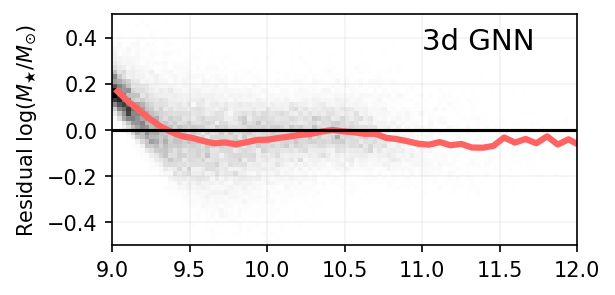

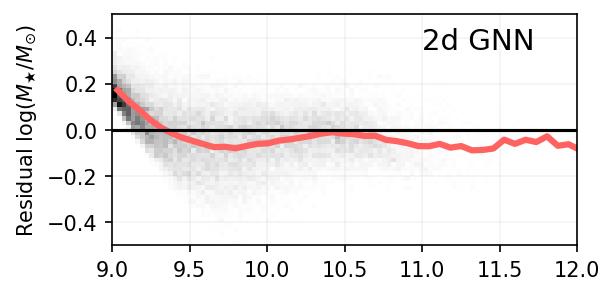

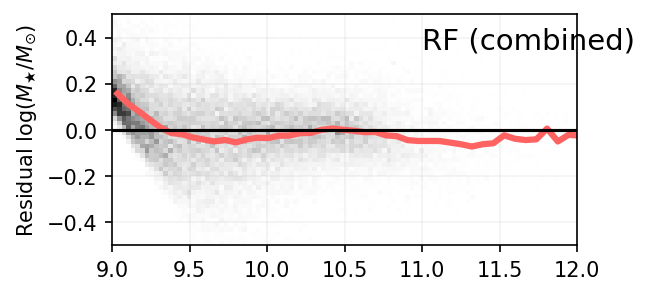

In [174]:
plt.figure(figsize=(4, 2), dpi=150)
plt.hist2d(df.log_Mstar, df.p_GNN_3d - df.log_Mstar, bins=(100, 50), range=[(9, 12), (-0.5, 0.5)], cmap="Greys")
mean_residual, bin_edges, _ = binned_statistic(df.log_Mstar, df.p_GNN_3d - df.log_Mstar, "mean", bins=50)
plt.plot((bin_edges[:-1] + bin_edges[1:]) / 2, mean_residual, c=c3, lw=3)
plt.grid(alpha=0.15)
plt.axhline(0, c="k")
plt.text(11, 0.35, "3d GNN", fontsize=14)
plt.ylabel("Residual log($M_{\\bigstar}/M_{\\odot}$)")
plt.show()


plt.figure(figsize=(4, 2), dpi=150)
plt.hist2d(df.log_Mstar, df.p_GNN_2d - df.log_Mstar, bins=(100, 50), range=[(9, 12), (-0.5, 0.5)], cmap="Greys")
mean_residual, bin_edges, _ = binned_statistic(df.log_Mstar, df.p_GNN_2d - df.log_Mstar, "mean", bins=50)
plt.plot((bin_edges[:-1] + bin_edges[1:]) / 2, mean_residual, c=c3, lw=3)
plt.grid(alpha=0.15)
plt.axhline(0, c="k")
plt.text(11, 0.35, "2d GNN", fontsize=14)
plt.ylabel("Residual log($M_{\\bigstar}/M_{\\odot}$)")
plt.show()

plt.figure(figsize=(4, 2), dpi=150)
plt.hist2d(df.log_Mstar, df.p_RF_combined - df.log_Mstar, bins=(100, 50), range=[(9, 12), (-0.5, 0.5)], cmap="Greys")
mean_residual, bin_edges, _ = binned_statistic(df.log_Mstar, df.p_RF_combined - df.log_Mstar, "mean", bins=50)
plt.plot((bin_edges[:-1] + bin_edges[1:]) / 2, mean_residual, c=c3, lw=3)
plt.grid(alpha=0.15)
plt.axhline(0, c="k")
plt.text(11, 0.35, "RF (combined)", fontsize=14)
plt.ylabel("Residual log($M_{\\bigstar}/M_{\\odot}$)")
plt.show()

Text(0.5, 0, 'Residual log($M_{\\bigstar}/M_{\\odot}$)')

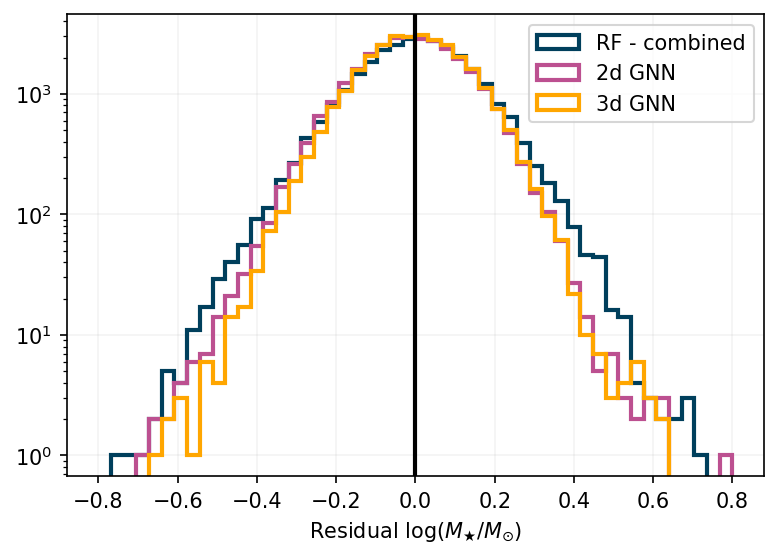

In [175]:
plt.figure(figsize=(6, 4), dpi=150)
plt.hist(df.p_RF_combined - df.log_Mstar, log=True, bins=50, histtype="step", range=[-0.8, 0.8], color=c0, lw=2, label="RF - combined")
plt.hist(df.p_GNN_2d - df.log_Mstar, log=True, bins=50, histtype="step", range=[-0.8, 0.8], color=c2, lw=2, label='2d GNN')
plt.hist(df.p_GNN_3d - df.log_Mstar, log=True, bins=50, histtype="step", range=[-0.8, 0.8], color=c4, lw=2, label='3d GNN')
plt.axvline(0, c='k', lw=2, zorder=9)
plt.legend()
plt.grid(alpha=0.15)
plt.xlabel("Residual log($M_{\\bigstar}/M_{\\odot}$)")


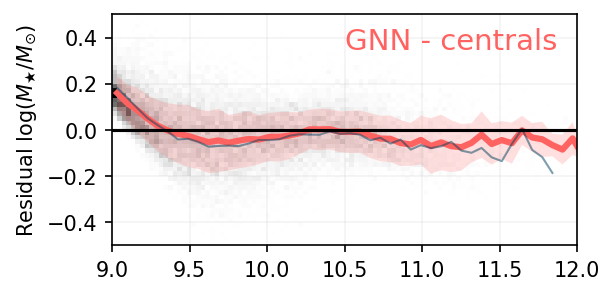

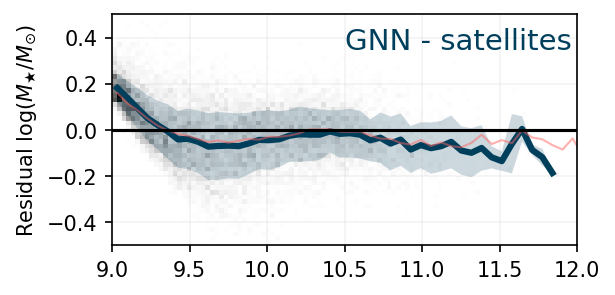

In [189]:
# split on centrals/sats

mean_residual_centrals, bin_edges, _ = binned_statistic(df[df.is_central].log_Mstar, df[df.is_central].p_GNN_3d - df[df.is_central].log_Mstar, "mean", bins=50)
std_residual_centrals, bin_edges, _ = binned_statistic(df[df.is_central].log_Mstar, df[df.is_central].p_GNN_3d - df[df.is_central].log_Mstar, "std", bins=50)

mean_residual_satellites, bin_edges, _ = binned_statistic(df[~df.is_central].log_Mstar, df[~df.is_central].p_GNN_3d - df[~df.is_central].log_Mstar, "mean", bins=50)
std_residual_satellites, bin_edges, _ = binned_statistic(df[~df.is_central].log_Mstar, df[~df.is_central].p_GNN_3d - df[~df.is_central].log_Mstar, "std", bins=50)


plt.figure(figsize=(4, 2), dpi=150)
plt.hist2d(df[df.is_central].log_Mstar, df[df.is_central].p_GNN_3d - df[df.is_central].log_Mstar, bins=(100, 50), range=[(9, 12), (-0.5, 0.5)], cmap="Greys")
plt.plot((bin_edges[:-1] + bin_edges[1:]) / 2, mean_residual_centrals, c=c3, lw=3)
plt.plot((bin_edges[:-1] + bin_edges[1:]) / 2, mean_residual_satellites, c=c0, lw=1, alpha=0.5)
plt.fill_between((bin_edges[:-1] + bin_edges[1:]) / 2, mean_residual_centrals-std_residual_centrals, mean_residual_centrals+std_residual_centrals, color=c3, alpha=0.2, lw=0)
plt.grid(alpha=0.15)
plt.axhline(0, c="k")
plt.text(10.5, 0.35, "GNN - centrals", fontsize=14, c=c3)
plt.ylabel("Residual log($M_{\\bigstar}/M_{\\odot}$)")
plt.show()

plt.figure(figsize=(4, 2), dpi=150)
plt.hist2d(df[~df.is_central].log_Mstar, df[~df.is_central].p_GNN_3d - df[~df.is_central].log_Mstar, bins=(100, 50), range=[(9, 12), (-0.5, 0.5)], cmap="Greys")
plt.plot((bin_edges[:-1] + bin_edges[1:]) / 2, mean_residual_satellites, c=c0, lw=3)
plt.plot((bin_edges[:-1] + bin_edges[1:]) / 2, mean_residual_centrals, c=c3, lw=1, alpha=0.5)
plt.fill_between((bin_edges[:-1] + bin_edges[1:]) / 2, mean_residual_satellites-std_residual_satellites, mean_residual_satellites+std_residual_satellites, color=c0, alpha=0.2, lw=0)
plt.grid(alpha=0.15)
plt.axhline(0, c="k")
plt.text(10.5, 0.35, "GNN - satellites", fontsize=14, c=c0)
plt.ylabel("Residual log($M_{\\bigstar}/M_{\\odot}$)")
plt.show()

In [191]:
metrics_GNN_centrals = get_metrics(df[df.is_central].p_GNN_3d, df[df.is_central].log_Mstar)
print("GNN ($(3d)$ - centrals) & 8 & " + " & ".join([f"{m:.3f}" for m in metrics_GNN_centrals]) + "\\\\")

metrics_GNN_satellites = get_metrics(df[~df.is_central].p_GNN_3d, df[~df.is_central].log_Mstar)
print("GNN ($(3d)$ - satellites) & 8 & " + " & ".join([f"{m:.3f}" for m in metrics_GNN_satellites]) + "\\\\")

GNN ($(3d)$ - centrals) & 8 & 0.123 & 0.118 & 0.097 & 0.979 & 0.958 & 2.514 & 0.663\\
GNN ($(3d)$ - satellites) & 8 & 0.136 & 0.136 & 0.108 & 0.968 & 0.937 & -6.400 & 0.406\\


# Train on TNG300 and predict on TNG50

In [ ]:
test_path = osp.join(tng_base_path, 'cosmic_graphs', f'tng50-test.pkl')

make_webs(
    tng_base_path="../illustris_data/TNG50-1/output",
    data_path=test_path,
    snapshot=snapshot, 
    r_link=r_link, 
    pad=0, 
    split=1,
    cuts=cuts, 
    use_gal=use_gal, 
    h=h, 
    undirected=undirected, 
    periodic=periodic,
    use_loops=use_loops
)


data_tng50 = pickle.load(open(test_path, 'rb'))

0 0 0


/home/john/miniconda3/envs/pyg/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
data_tng50

[Data(x=[2319, 8], edge_index=[2, 10124], edge_attr=[10124, 3], y=[2319, 1], pos=[2319, 3])]

In [ ]:
test_loader = DataLoader(data_tng50, batch_size=batch_size, shuffle=False)


In [ ]:
_, _, p_test, y_test, _ = validate(test_loader, model, device)

p_test = p_test.reshape((-1, 1))

In [ ]:
p_log_Mstar_tng50 = p_test[:, 0]

y_log_Mstar_tng50 = y_test[:, 0]

# for plotting purposes
log_Mhalo_tng50 = np.concatenate([d.x[:, -2] for d in data_tng50])

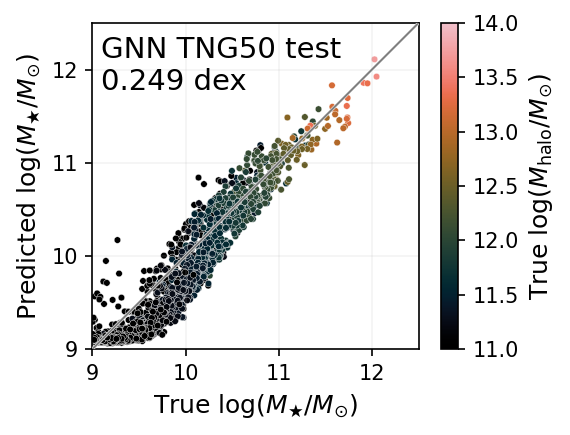

In [ ]:
plt.figure(figsize=(4, 3), dpi=150)
plt.scatter(y_log_Mstar_tng50, p_log_Mstar_tng50, c=log_Mhalo_tng50, edgecolor='white', linewidths=0.2, s=10, cmap=cmr.dusk, vmin=11, vmax=14)
cb = plt.colorbar()
cb.set_label("True log($M_{\\rm halo}/M_{\\odot}}$)", fontsize=12)
plt.text(0.025, 0.96, f"GNN TNG50 test\n{np.sqrt(np.mean((p_log_Mstar_tng50 - y_log_Mstar_tng50)**2)):.3f} dex", va="top", transform=plt.gca().transAxes, fontsize=14)
plt.plot([0, 50], [0, 50], lw=1.5, c='w', zorder=9)
plt.plot([0, 50], [0, 50], lw=1, c='0.5', zorder=10)
plt.grid(alpha=0.15)
plt.xlim(9, 12.5)
plt.ylim(9, 12.5)
plt.xticks([9, 10, 11, 12])
plt.yticks([9, 10, 11, 12])

plt.xlabel("True log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=12)
plt.ylabel("Predicted log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=12)
plt.gca().set_aspect("equal")
# plt.title("Equivariant Graph Neural Network", fontsize=14)
plt.tight_layout()

# plt.savefig(f'{ROOT}/results/painting-galaxies/GNN.pdf')